### Running MAST and testing the calibration

In [1]:
library(MAST)
library(Seurat)
library(SeuratData)
library(cowplot)
library(patchwork)
library(data.table)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

### Get the seurat version and get cells/genes for standardization

In [2]:
# InstallData('ifnb')

In [3]:
# install.packages("https://seurat.nygenome.org/src/contrib/ifnb.SeuratData_3.1.0.tar.gz", repos = NULL, type = "source")

In [4]:
library(ifnb.SeuratData)

In [5]:
data("ifnb")

In [6]:
ifnb <- subset(x = ifnb, subset = seurat_annotations == "CD14 Mono")


In [7]:
write.csv(ifnb[[]], '/data_volume/memento/method_comparison/mast/seurat_full.csv')
write.csv(rownames(ifnb), '/data_volume/memento/method_comparison/mast/seurat_genes.csv')

In [8]:
ifnb <- NormalizeData(object = ifnb)

### Run memento and save metadata/result

### Run full and partial MASTs

In [9]:
scaRaw <- FromMatrix(
    as.matrix(GetAssayData(object = ifnb,slot="data")), 
    ifnb[[]], ifnb[["RNA"]][[]])

`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.



In [10]:
rownames(scaRaw) <- gsub("\\.", "-", rownames(scaRaw))
colnames(scaRaw) <- gsub("\\.", "-", colnames(scaRaw))


In [11]:
sca <- scaRaw

In [16]:
mem_meta = read.table('/data_volume/memento/method_comparison/memento/meta_full.csv', sep=',', header=1)
mem_genes = read.table('/data_volume/memento/method_comparison/memento/memento_full.csv', sep=',', header=1)

In [17]:
sca <- sca[mem_genes$gene, mem_meta$index]

In [18]:
cond<-factor(colData(sca)$stim)
cond<-relevel(cond,"CTRL")
colData(sca)$condition<-cond
zlmCond <- zlm(~condition + nCount_RNA, sca)


Done!



In [19]:
summaryCond <- summary(zlmCond, doLRT='conditionSTIM')

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



In [20]:
print(summaryCond, n=4)


Fitted zlm with top 4 genes per contrast:
( log fold change Z-score )
 primerid  conditionSTIM nCount_RNA
 ATP6V1G1     1.3          38.3*   
 HNRNPA2B1   -4.7          38.1*   
 IFI6        76.2*         20.0    
 IFITM3      77.3*          5.3    
 ISG15       84.2*          3.8    
 LY6E        96.4*         15.3    
 TALDO1     -10.7          38.5*   
 UBC          3.2          36.7*   


In [21]:
FCTHRESHOLD <- log2(1.5)


In [22]:
summaryDt <- summaryCond$datatable
fcHurdle <- merge(summaryDt[contrast=='conditionSTIM' & component=='H',.(primerid, `Pr(>Chisq)`)], #hurdle P values
                      summaryDt[contrast=='conditionSTIM' & component=='logFC', .(primerid, coef, ci.hi, ci.lo)], by='primerid') #logFC coefficients

fcHurdle[,fdr:=p.adjust(`Pr(>Chisq)`, 'fdr')]
fcHurdleSig <- merge(fcHurdle[fdr<.05], as.data.table(mcols(sca)), by='primerid')
# setorder(fcHurdleSig, fdr)

In [23]:
head(fcHurdle)

primerid,Pr(>Chisq),coef,ci.hi,ci.lo,fdr
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAED1,4.284176e-17,0.093112954,0.12455775,0.061668157,1.095687e-16
ABHD12,3.523088e-01,0.011609475,0.02870430,-0.005485353,3.834711e-01
ABHD3,5.066569e-01,0.008454987,0.02327590,-0.006365931,5.371944e-01
ABI1,2.918622e-06,0.042820837,0.06422044,0.021421232,4.773139e-06
ABI3,4.317125e-12,-0.075081966,-0.04772237,-0.102441565,9.261447e-12
ABRACL,1.177336e-04,0.061733300,0.09516367,0.028302930,1.746152e-04


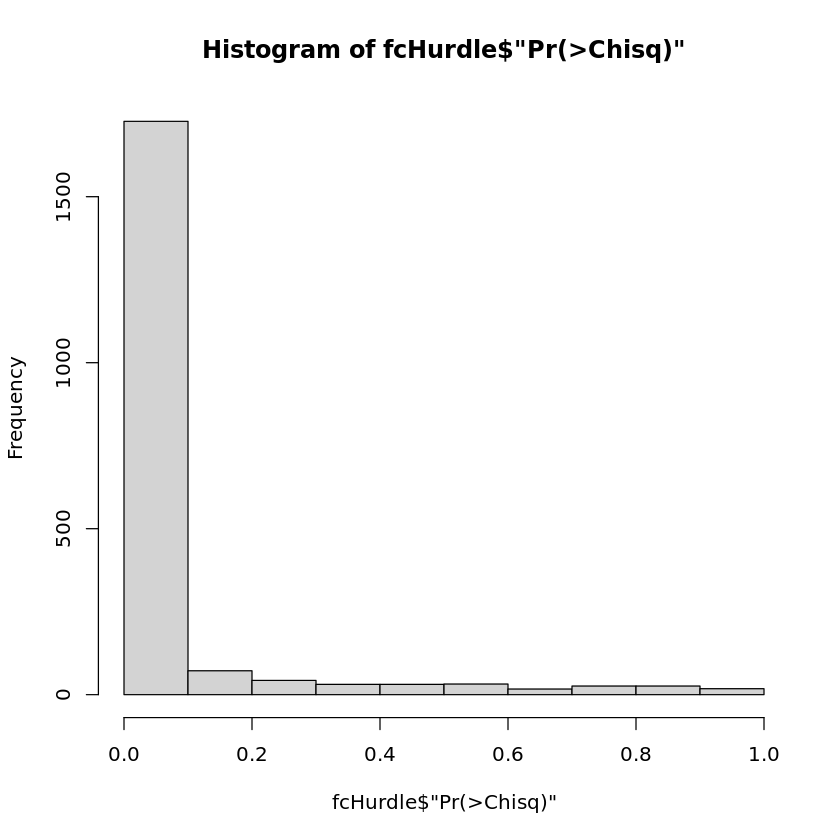

In [24]:
hist(fcHurdle$'Pr(>Chisq)')

In [25]:
write.csv(fcHurdle, '/data_volume/memento/method_comparison/mast/MAST_full_demux.csv')

### Run mast repeatedly with partial data

In [26]:
library(ifnb.SeuratData)

In [27]:
data("ifnb")
ifnb <- subset(x = ifnb, subset = seurat_annotations == "CD14 Mono")
ifnb <- NormalizeData(object = ifnb)

In [28]:
# Use expressed genes from full dataset
rep_num <- 1
for (trial in 1:2){

    scaRaw <- FromMatrix(
        as.matrix(GetAssayData(object = ifnb,slot="data")), 
        ifnb[[]], ifnb[["RNA"]][[]])
    
    rownames(scaRaw) <- gsub("\\.", "-", rownames(scaRaw))
    colnames(scaRaw) <- gsub("\\.", "-", colnames(scaRaw))
    
    sca <- scaRaw
    
    mem_meta <- read.table(
        paste('/data_volume/memento/method_comparison/memento/meta_equal_rep_', trial, '.csv', sep=''),
        sep=',', header=1)
    mem_genes <- read.table(
        paste('/data_volume/memento/method_comparison/memento/memento_equal_rep_', trial, '.csv', sep=''),
        sep=',', header=1)
    
    sca <- sca[mem_genes$gene, mem_meta$index]
    cond<-factor(colData(sca)$stim)
    cond<-relevel(cond,"CTRL")
    colData(sca)$condition<-cond
    zlmCond <- zlm(~condition + nCount_RNA, sca)
    summaryCond <- summary(zlmCond, doLRT='conditionSTIM')

    summaryDt <- summaryCond$datatable
    fcHurdle <- merge(summaryDt[contrast=='conditionSTIM' & component=='H',.(primerid, `Pr(>Chisq)`)], #hurdle P values
                          summaryDt[contrast=='conditionSTIM' & component=='logFC', .(primerid, coef, ci.hi, ci.lo)], by='primerid') #logFC coefficients
    print(colnames(sca)[1:5])
    write.csv(fcHurdle, paste('/data_volume/memento/method_comparison/mast/MAST_equal_rep_',trial, '.csv', sep=''))
    }

`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "ACGGATTGTCCGTC-1" "ACAAATTGACCTGA-1" "CAATAATGGAATCC-1" "AGGGCGCTACGGGA-1"
[5] "GTAGTGTGTTATCC-1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "TAGTCTTGGCAAGG-1" "TTTGACTGCCCACT-1" "ACGAACACTAGACC-1" "CAAGCCCTTCAAGC-1"
[5] "ATTCAAGAACACAC-1"
